<img src='images/Northwind_ERD_updated.png.'>

List of testing:
- One sample z test (know pop variance) - will not be able to test with this data
    - Kolmogorov-Smirnov Test
- One sample t test (don't know pop variance)
- Two sample t test (unpaired sample)
    - Mann-Whitney Test
- One Sample Proportion Testing
- Chi-Square
- Two Sample Proportion Testing/Two Sample Chi Square
- Bayesian Testing

# Question

### Does having a product on reorder increase spending? Is this connected to frieght?

Both questions can be tested using an ANOVA.

# Hypothesis

## H0: no effect - there is no change to spending based on reorder or frieght costs
## HA: there is an effect - there is a change to spending based on reorder or frieght costs

## Feature: spending
## Target: reorder/frieght

# Methodology

To evaluate the [data], I have chosen to use the following steps:
- Obtain Data
- Scrub Data
- Explore Data
- Modeling
- Interpret

I have found that the OSEMN method explains the data science process, and gives context to exploring data.

# Obtain Data
[Data comes from...]

In [125]:
# develop class
pass

In [126]:
# import py file
from classes import Pvalue

In [127]:
# import libraries
import pandas as pd
import sqlite3

import numpy as np
from numpy import std, mean, sqrt
import scipy.stats as stats
from scipy.stats import wilcoxon
from statsmodels.stats.power import tt_ind_solve_power
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('Solarize_Light2')
import seaborn as sns

idx = pd.IndexSlice

In [206]:
# import data
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

# All data
cur.execute("""SELECT 'Order'.Id, OrderDate, ShipVia, Freight, ReorderLevel, Product.UnitPrice*Quantity as ItemTotal, OrderDetail.ProductId, OrderDetail.Discount
               FROM OrderDetail
               LEFT JOIN 'Order' ON OrderDetail.OrderID = 'Order'.Id
               JOIN Product ON OrderDetail.ProductId = Product.Id
               ;""")
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head()

,Id,OrderDate,ShipVia,Freight,ReorderLevel,ItemTotal,ProductId,Discount
0,10248,2012-07-04,3,32.38,30,252.00,11,0.0
1,10248,2012-07-04,3,32.38,0,140.00,42,0.0
2,10248,2012-07-04,3,32.38,0,174.00,72,0.0
3,10249,2012-07-05,1,11.61,0,209.25,14,0.0
4,10249,2012-07-05,1,11.61,10,2120.00,51,0.0


In [129]:
multi = df.copy(deep=True)
mulit = multi.set_index(['Id', 'ProductId', 'ReorderLevel', 'ShipVia'], inplace=True)
multi.head()

OrderDate  Freight  ItemTotal  Discount
Id    ProductId ReorderLevel ShipVia                                          
10248 11        30           3        2012-07-04    32.38     252.00       0.0
      42        0            3        2012-07-04    32.38     140.00       0.0
      72        0            3        2012-07-04    32.38     174.00       0.0
10249 14        0            1        2012-07-05    11.61     209.25       0.0
      51        10           1        2012-07-05    11.61    2120.00       0.0

In [130]:
shipping = multi.unstack('ShipVia')['ItemTotal']
shipping

ShipVia                             1     2      3
Id    ProductId ReorderLevel                      
10248 11        30                NaN   NaN  252.0
      42        0                 NaN   NaN  140.0
      72        0                 NaN   NaN  174.0
10249 14        0              209.25   NaN    NaN
      51        10            2120.00   NaN    NaN
...                               ...   ...    ...
11077 64        30                NaN  66.5    NaN
      66        20                NaN  17.0    NaN
      73        5                 NaN  30.0    NaN
      75        25                NaN  31.0    NaN
      77        15                NaN  26.0    NaN

[2155 rows x 3 columns]

In [131]:
shipping_reorder = shipping.unstack('ReorderLevel')
shipping_reorder

ShipVia               1                               2            ...        \
ReorderLevel         0   5       10  15  20  25  30  0     5   10  ...    20   
Id    ProductId                                                    ...         
10248 11            NaN NaN     NaN NaN NaN NaN NaN NaN   NaN NaN  ...   NaN   
      42            NaN NaN     NaN NaN NaN NaN NaN NaN   NaN NaN  ...   NaN   
      72            NaN NaN     NaN NaN NaN NaN NaN NaN   NaN NaN  ...   NaN   
10249 14         209.25 NaN     NaN NaN NaN NaN NaN NaN   NaN NaN  ...   NaN   
      51            NaN NaN  2120.0 NaN NaN NaN NaN NaN   NaN NaN  ...   NaN   
...                 ...  ..     ...  ..  ..  ..  ..  ..   ...  ..  ...   ...   
11077 64            NaN NaN     NaN NaN NaN NaN NaN NaN   NaN NaN  ...   NaN   
      66            NaN NaN     NaN NaN NaN NaN NaN NaN   NaN NaN  ...  17.0   
      73            NaN NaN     NaN NaN NaN NaN NaN NaN  30.0 NaN  ...   NaN   
      75            NaN NaN     NaN NaN NaN NaN NaN NaN   NaN NaN  ...   NaN   
      77            NaN NaN     NaN NaN NaN NaN NaN NaN   NaN NaN  ...   NaN   

ShipVia                          3                             
ReorderLevel       25    30     0   5   10  15  20  25     30  
Id    ProductId                                                
10248 11          NaN   NaN    NaN NaN NaN NaN NaN NaN  252.0  
      42          NaN   NaN  140.0 NaN NaN NaN NaN NaN    NaN  
      72          NaN   NaN  174.0 NaN NaN NaN NaN NaN    NaN  
10249 14          NaN   NaN    NaN NaN NaN NaN NaN NaN    NaN  
      51          NaN   NaN    NaN NaN NaN NaN NaN NaN    NaN  
...               ...   ...    ...  ..  ..  ..  ..  ..    ...  
11077 64          NaN  66.5    NaN NaN NaN NaN NaN NaN    NaN  
      66          NaN   NaN    NaN NaN NaN NaN NaN NaN    NaN  
      73          NaN   NaN    NaN NaN NaN NaN NaN NaN    NaN  
      75         31.0   NaN    NaN NaN NaN NaN NaN NaN    NaN  
      77          NaN   NaN    NaN NaN NaN NaN NaN NaN    NaN  

[2155 rows x 21 columns]

Initial observations of data go here

In [132]:
def index_level_dtypes(df):
    return [f"{df.index.names[i]}: {df.index.get_level_values(n).dtype}"
            for i, n in enumerate(df.index.names)]

index_level_dtypes(shipping_reorder)

['Id: int64', 'ProductId: int64']

# Scrub Data

The following scrubbing techniques were applied to the original data:
- Manage n/a data types
- Delete duplicate rows
- Correct data types
- Find outliers

### Manage n/a data types

In [134]:
# nans identification
print(len(df))
df.isna().sum()

2155


Id              0
OrderDate       0
ShipVia         0
Freight         0
ReorderLevel    0
ItemTotal       0
ProductId       0
Discount        0
dtype: int64

### Delete duplicate data

In [135]:
# identification of duplicate data
print('duplicated rows: ' + str(df.duplicated().sum()))

duplicated rows: 0


In [136]:
# code to drop duplicate row if necessary
# df.drop_duplicates(inplace=True)
# print('duplicated rows: ' + str(df.duplicated().sum()))

### Correct data types

First, let's see what the data types for this data set are.

In [137]:
# data type identification
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 8 columns):
Id              2155 non-null int64
OrderDate       2155 non-null object
ShipVia         2155 non-null int64
Freight         2155 non-null float64
ReorderLevel    2155 non-null int64
ItemTotal       2155 non-null float64
ProductId       2155 non-null int64
Discount        2155 non-null float64
dtypes: float64(3), int64(4), object(1)
memory usage: 134.8+ KB


In [138]:
# correction to data type if necessary
df.columns

Index(['Id', 'OrderDate', 'ShipVia', 'Freight', 'ReorderLevel', 'ItemTotal',
       'ProductId', 'Discount'],
      dtype='object')

### Find outliers

In [139]:
# outlier identification
pass

In [140]:
# management of outliers
pass

Observations about data types

# Explore Data

For a quick preview of what we have to work with, we'll use the describe method.

In [141]:
# describe data
df.describe()

,Id,ShipVia,Freight,ReorderLevel,ItemTotal,ProductId,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,1.999536,96.197726,11.900232,672.560237,40.793039,0.056167
std,241.378032,0.774177,133.011272,10.791421,1110.261427,22.159019,0.083450
min,10248.000000,1.000000,0.020000,0.000000,6.000000,1.000000,0.000000
25%,10451.000000,1.000000,19.610000,0.000000,170.500000,22.000000,0.000000
50%,10657.000000,2.000000,53.800000,10.000000,380.000000,41.000000,0.000000
75%,10862.500000,3.000000,120.920000,20.000000,760.000000,60.000000,0.100000
max,11077.000000,3.000000,1007.640000,30.000000,15810.000000,77.000000,0.250000


Observations about df.describe()

### Visualize data

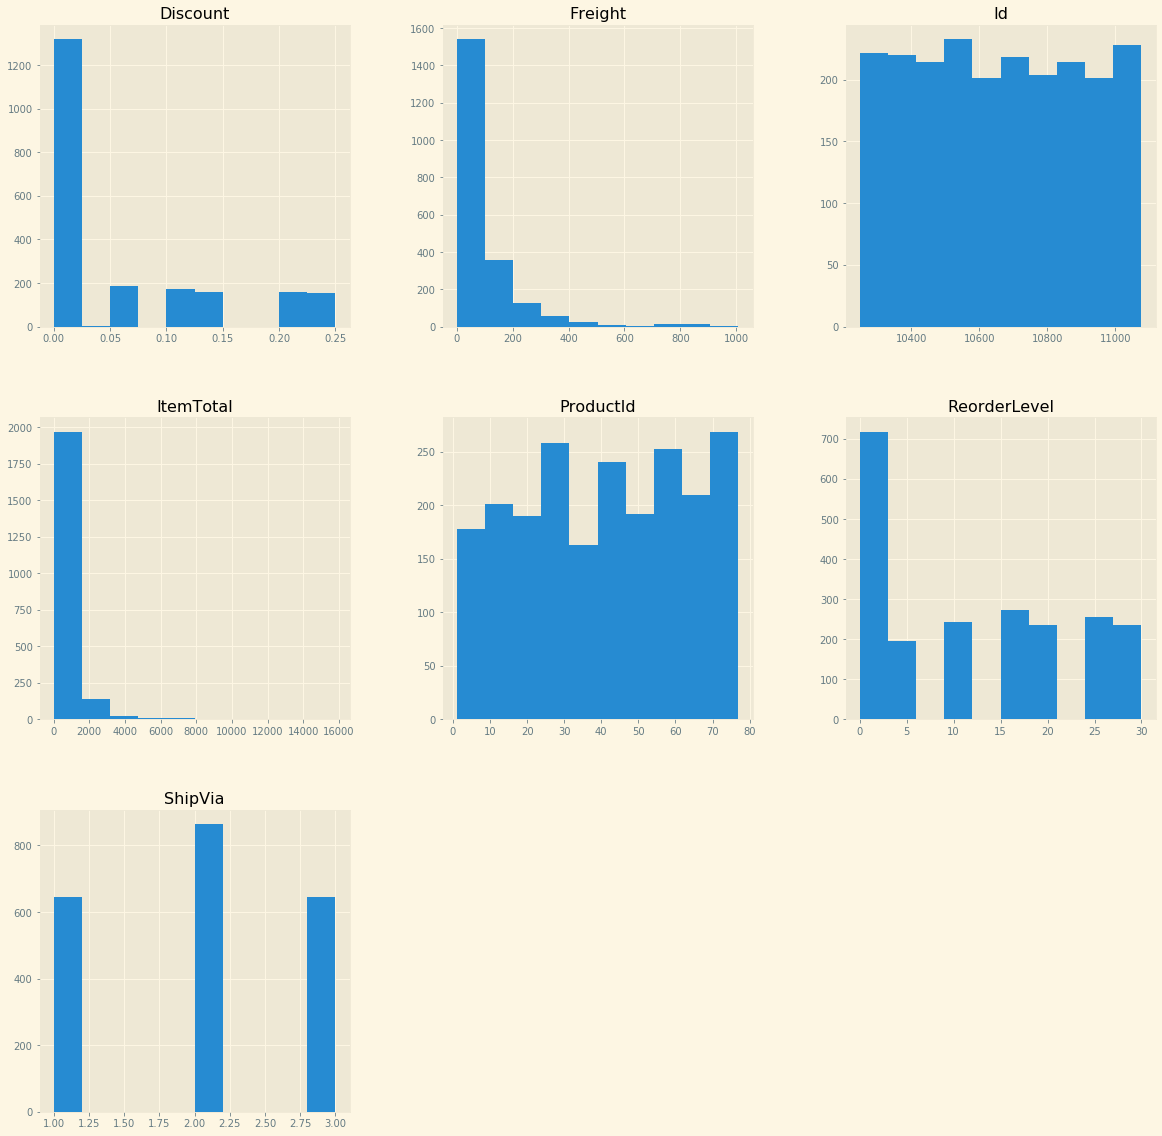

In [142]:
# visualize data
df.hist(figsize=(20,20));

Observations about visual

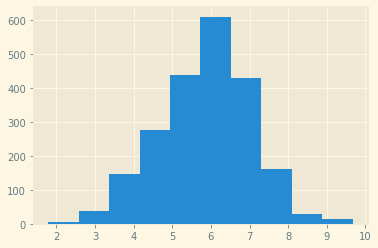

In [143]:
df['ItemTotal'] = df['ItemTotal'].map(lambda x: np.log(x))
df.ItemTotal.hist()

### Sort data

Plan and justification of sorting data

In [144]:
# sort data
df_reorder = df[df['ReorderLevel'] != 0]
df_reorder

,Id,OrderDate,ShipVia,Freight,ReorderLevel,ItemTotal,ProductId,Discount
0,10248,2012-07-04,3,32.38,30,5.529429,11,0.00
4,10249,2012-07-05,1,11.61,10,7.659171,51,0.00
5,10250,2012-07-08,2,65.83,10,4.569543,41,0.00
6,10250,2012-07-08,2,65.83,10,7.525640,51,0.15
8,10251,2012-07-08,1,41.34,25,4.836282,22,0.05
...,...,...,...,...,...,...,...,...
2150,11077,2014-05-06,2,8.53,30,4.197202,64,0.03
2151,11077,2014-05-06,2,8.53,20,2.833213,66,0.00
2152,11077,2014-05-06,2,8.53,5,3.401197,73,0.01
2153,11077,2014-05-06,2,8.53,25,3.433987,75,0.00


In [145]:
df_no_reorder = df[df['ReorderLevel'] == 0]
df_no_reorder

,Id,OrderDate,ShipVia,Freight,ReorderLevel,ItemTotal,ProductId,Discount
1,10248,2012-07-04,3,32.38,0,4.941642,42,0.00
2,10248,2012-07-04,3,32.38,0,5.159055,72,0.00
3,10249,2012-07-05,1,11.61,0,5.343530,14,0.00
7,10250,2012-07-08,2,65.83,0,5.754951,65,0.15
10,10251,2012-07-08,1,41.34,0,6.042633,65,0.00
...,...,...,...,...,...,...,...,...
2137,11077,2014-05-06,2,8.53,0,4.330733,12,0.05
2139,11077,2014-05-06,2,8.53,0,3.146305,14,0.03
2141,11077,2014-05-06,2,8.53,0,4.394449,20,0.04
2146,11077,2014-05-06,2,8.53,0,3.583519,46,0.02


Observations about sorted data

### Develop feature

In [211]:
# create features
df_str = df.copy(deep=True)
df['Reorder'] = [1 if x != 0 else 0 for x in df['ReorderLevel']]
df_str['Reorder'] = ['Reorder' if x != 0 else 'No Reorder' for x in df['ReorderLevel']]
for x, y in enumerate(df_str['ReorderLevel']):
    if y == 0:
        df_str.loc[x,'ReorderLevel'] = 'Zero'
    elif y == 5:
        df_str.loc[x,'ReorderLevel'] = 'Five'
    elif y == 10:
        df_str.loc[x,'ReorderLevel'] = 'Ten'
    elif y == 15:
        df_str.loc[x,'ReorderLevel'] = 'Fifteen'
    elif y == 20:
        df_str.loc[x,'ReorderLevel'] = 'Twenty'
    elif y == 25:
        df_str.loc[x,'ReorderLevel'] = 'Twenty Five'
    else:
        df_str.loc[x,'ReorderLevel'] = 'Thirty'
print(df.head())
print(df_str.head())

      Id   OrderDate  ShipVia  Freight  ReorderLevel  ItemTotal  ProductId  \
0  10248  2012-07-04        3    32.38            30     252.00         11   
1  10248  2012-07-04        3    32.38             0     140.00         42   
2  10248  2012-07-04        3    32.38             0     174.00         72   
3  10249  2012-07-05        1    11.61             0     209.25         14   
4  10249  2012-07-05        1    11.61            10    2120.00         51   

   Discount  Reorder  
0       0.0        1  
1       0.0        0  
2       0.0        0  
3       0.0        0  
4       0.0        1  
      Id   OrderDate  ShipVia  Freight ReorderLevel  ItemTotal  ProductId  \
0  10248  2012-07-04        3    32.38       Thirty     252.00         11   
1  10248  2012-07-04        3    32.38         Zero     140.00         42   
2  10248  2012-07-04        3    32.38         Zero     174.00         72   
3  10249  2012-07-05        1    11.61         Zero     209.25         14   
4  10249

In [212]:
df_str['ShipVia'] = [str(x) for x in df['ShipVia']]

# Model Data
Below is the model after scrubbing and exploring have been managed, let's see what the model picks up.

### Data normality

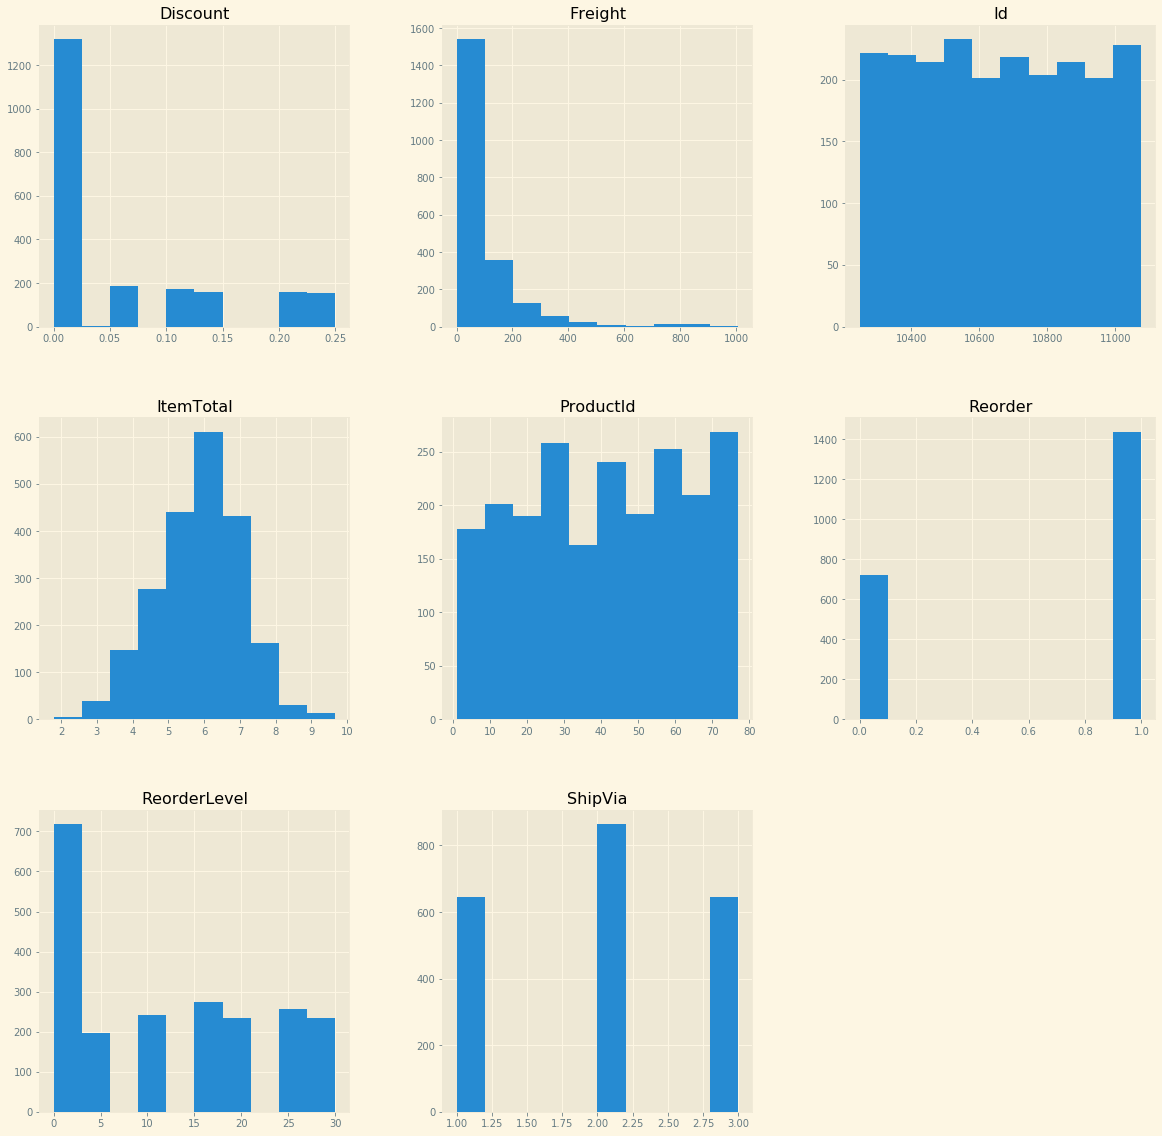

In [149]:
# visual/code for data normality
df.hist(figsize=(20,20));

### Standard deviation

In [150]:
# standard deviation for target variable
print('ItemTotal')
print('mean: ' + str(mean(df['ItemTotal'])))
print('standard deviation: ' + str(std(df['ItemTotal'])))

ItemTotal
mean: 5.859902046483519
standard deviation: 1.164650382603087


### Basic testing

In [151]:
# set up variables for this particular test
alpha = 0.05

In [213]:
# test
sm.stats.anova_lm(ols('ItemTotal ~ ShipVia + Reorder', data=df_str).fit())

,df,sum_sq,mean_sq,F,PR(>F)
ShipVia,2.0,3.445841e+06,1.722920e+06,1.422992,2.412186e-01
Reorder,1.0,4.737530e+07,4.737530e+07,39.128143,4.774064e-10
Residual,2151.0,2.604373e+09,1.210773e+06,NaN,NaN


In [214]:
# result
p_value = [2.412186*10**-1, 4.774064*10**-10]

In [215]:
# evaluation of result
for x in p_value:
    if alpha > x:
        print('Reject the null hypothesis')
    else:
        print('Fail to reject the null hypothesis')

Fail to reject the null hypothesis
Reject the null hypothesis


Summarize results and determine next steps. Might include verification of sample size, error types, non-parametric testing, or a deepening of understanding

### Verification techniques
#### Non-parametric testing

In [216]:
# non-parametric testing variables
shipVia1 = df[df['ShipVia'] == 1]
shipVia1_reorder0 = shipVia1[shipVia1['Reorder'] == 0]['ItemTotal']
shipVia1_reorder1 = shipVia1[shipVia1['Reorder'] == 1]['ItemTotal']
shipVia2 = df[df['ShipVia'] == 2]
shipVia2_reorder0 = shipVia2[shipVia2['Reorder'] == 0]['ItemTotal']
shipVia2_reorder1 = shipVia2[shipVia2['Reorder'] == 1]['ItemTotal']
shipVia3 = df[df['ShipVia'] == 3]
shipVia3_reorder0 = shipVia3[shipVia3['Reorder'] == 0]['ItemTotal']
shipVia3_reorder1 = shipVia3[shipVia3['Reorder'] == 1]['ItemTotal']

In [217]:
# non-parametric test
stats.kruskal(shipVia1_reorder0, shipVia1_reorder1, shipVia2_reorder0, shipVia2_reorder1, shipVia3_reorder0, shipVia3_reorder1)

KruskalResult(statistic=120.67769879906302, pvalue=2.2551786635363805e-24)

In [218]:
# result
p_value = 2.2550811681212016*10**-24

In [219]:
# evaluation of results
if alpha > p_value:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Reject the null hypothesis


Oberservations based on new finding

In [220]:
tukey_results = pairwise_tukeyhsd(df_str['ItemTotal'], df_str['ShipVia']+df_str['Reorder'])
tukey_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
1No Reorder,1Reorder,-229.0169,0.1269,-491.3169,33.2831,False
1No Reorder,2No Reorder,220.5391,0.2298,-63.0737,504.152,False
1No Reorder,2Reorder,-197.3167,0.2192,-448.4028,53.7693,False
1No Reorder,3No Reorder,93.8362,0.9,-208.1155,395.788,False
1No Reorder,3Reorder,-168.6428,0.4482,-431.4511,94.1654,False
1Reorder,2No Reorder,449.5561,0.001,210.3523,688.7599,True
1Reorder,2Reorder,31.7002,0.9,-167.8654,231.2658,False
1Reorder,3No Reorder,322.8532,0.0056,62.1674,583.539,True
1Reorder,3Reorder,60.3741,0.9,-153.753,274.5012,False
2No Reorder,2Reorder,-417.8559,0.001,-644.7069,-191.0049,True


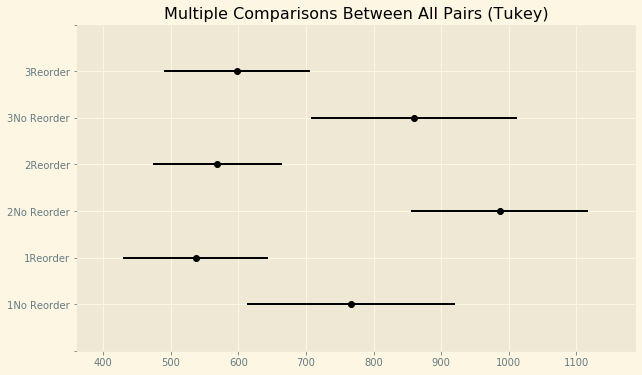

In [221]:
tukey_results.plot_simultaneous()
plt.show()

Oberservations based on new finding

#### Effect size

In [161]:
# effect size variables
pass

In [232]:
# effect size test
def cohen_d_two_samp(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)
effect_size = cohen_d_two_samp(df['ItemTotal'], df['ShipVia']+df['ReorderLevel'])
effect_size

0.8389397874687722

Obeservations about effect size

#### Power and error

In [233]:
# power variables
effect_size, nobs1, alpha = effect_size, df['ItemTotal'].shape[0], alpha

In [234]:
# power test
power = tt_ind_solve_power(effect_size=effect_size, nobs1=nobs1, alpha=alpha)
power

1.0

In [235]:
# evaluation of power test
type_2_error = 1 - power
type_2_error

0.0

Observations about power test

### Cross validatation

In [169]:
# test train split for testing preformed above
pass

### Extension of acquired knowledge
#### Deeper question
#### Hypothesis for deeper question

In [180]:
# deeper understanding variables
df_str['ReorderLevel'] = 

In [222]:
# deeper understanding test
sm.stats.anova_lm(ols('ItemTotal ~ ShipVia + ReorderLevel', data=df).fit())

,df,sum_sq,mean_sq,F,PR(>F)
ShipVia,1.0,1.732085e+06,1.732085e+06,1.417929,0.233876
ReorderLevel,1.0,2.466579e+07,2.466579e+07,20.192051,0.000007
Residual,2152.0,2.628796e+09,1.221559e+06,NaN,NaN


In [223]:
# deeper understanding result
p_value = [6.368921*10**-1, 1.030586*10**-7]

In [224]:
# deeper understanding evaluation of result
for x in p_value:
    if alpha > x:
        print('Reject the null hypothesis')
    else:
        print('Fail to reject the null hypothesis')

Fail to reject the null hypothesis
Reject the null hypothesis


In [225]:
# non-parametric testing variables
shipVia1 = df[df['ShipVia'] == 1]
shipVia1_reorder0 = shipVia1[shipVia1['ReorderLevel'] == 0]['ItemTotal']
shipVia1_reorder5 = shipVia1[shipVia1['ReorderLevel'] == 5]['ItemTotal']
shipVia1_reorder10 = shipVia1[shipVia1['ReorderLevel'] == 10]['ItemTotal']
shipVia1_reorder15 = shipVia1[shipVia1['ReorderLevel'] == 15]['ItemTotal']
shipVia1_reorder20 = shipVia1[shipVia1['ReorderLevel'] == 20]['ItemTotal']
shipVia1_reorder25 = shipVia1[shipVia1['ReorderLevel'] == 25]['ItemTotal']
shipVia1_reorder30 = shipVia1[shipVia1['ReorderLevel'] == 30]['ItemTotal']
shipVia2 = df[df['ShipVia'] == 2]
shipVia2_reorder0 = shipVia2[shipVia2['ReorderLevel'] == 0]['ItemTotal']
shipVia2_reorder5 = shipVia2[shipVia2['ReorderLevel'] == 5]['ItemTotal']
shipVia2_reorder10 = shipVia2[shipVia2['ReorderLevel'] == 10]['ItemTotal']
shipVia2_reorder15 = shipVia2[shipVia2['ReorderLevel'] == 15]['ItemTotal']
shipVia2_reorder20 = shipVia2[shipVia2['ReorderLevel'] == 20]['ItemTotal']
shipVia2_reorder25 = shipVia2[shipVia2['ReorderLevel'] == 25]['ItemTotal']
shipVia2_reorder30 = shipVia2[shipVia2['ReorderLevel'] == 30]['ItemTotal']
shipVia3 = df[df['ShipVia'] == 3]
shipVia3_reorder0 = shipVia3[shipVia3['ReorderLevel'] == 0]['ItemTotal']
shipVia3_reorder5 = shipVia3[shipVia3['ReorderLevel'] == 5]['ItemTotal']
shipVia3_reorder10 = shipVia3[shipVia3['ReorderLevel'] == 10]['ItemTotal']
shipVia3_reorder15 = shipVia3[shipVia3['ReorderLevel'] == 15]['ItemTotal']
shipVia3_reorder20 = shipVia3[shipVia3['ReorderLevel'] == 20]['ItemTotal']
shipVia3_reorder25 = shipVia3[shipVia3['ReorderLevel'] == 25]['ItemTotal']
shipVia3_reorder30 = shipVia3[shipVia3['ReorderLevel'] == 30]['ItemTotal']

In [226]:
# non-parametric test
stats.kruskal(shipVia1_reorder0, shipVia1_reorder5, shipVia1_reorder10, shipVia1_reorder15, shipVia1_reorder20, 
                     shipVia1_reorder25, shipVia1_reorder30, shipVia2_reorder0, shipVia2_reorder5, shipVia2_reorder10, 
                     shipVia2_reorder15, shipVia2_reorder20, shipVia2_reorder25, shipVia2_reorder30, shipVia3_reorder0, 
                     shipVia3_reorder5, shipVia3_reorder10, shipVia3_reorder15, shipVia3_reorder20, shipVia3_reorder25, 
                     shipVia3_reorder30)

KruskalResult(statistic=191.1760174190746, pvalue=6.208124121397785e-30)

In [227]:
# result
p_value = 6.208621981290592*10**-30

In [228]:
if alpha > p_value:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Reject the null hypothesis


In [229]:
tukey_results = pairwise_tukeyhsd(df_str['ItemTotal'], df_str['ShipVia']+df_str['ReorderLevel'])
tukey_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
1Fifteen,1Five,-371.7845,0.9,-1072.1458,328.5768,False
1Fifteen,1Ten,-289.904,0.9,-919.2557,339.4477,False
1Fifteen,1Thirty,-55.7721,0.9,-696.409,584.8647,False
1Fifteen,1Twenty,-400.4068,0.7261,-1023.5973,222.7837,False
1Fifteen,1Twenty Five,-303.0674,0.9,-920.4982,314.3634,False
1Fifteen,1Zero,-3.3628,0.9,-518.8785,512.1529,False
1Fifteen,2Fifteen,257.3663,0.9,-316.9143,831.6469,False
1Fifteen,2Five,-412.1303,0.6767,-1033.3582,209.0977,False
1Fifteen,2Ten,-295.7251,0.9,-893.4278,301.9777,False
1Fifteen,2Thirty,-151.8237,0.9,-746.6699,443.0225,False


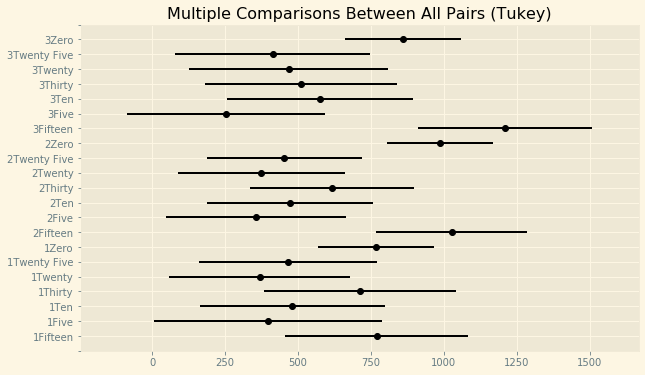

In [230]:
tukey_results.plot_simultaneous()
plt.show()

Observations based off of deeper understanding test

# Interpret

Conclusions about question overall commentary on hypothesis

### Additional visualizations

In [174]:
# visual for blah blah blah
pass

### Tools for use of discovered information

In [175]:
# function or equation used to test developed theories
pass

# Future Work

give a list of options for future exploration opportunities

# Resources

give credit where it is due